In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import sklearn.metrics as metrics
import pickle
import warnings
warnings.filterwarnings('ignore')

import altair as alt


from pandas.io.json import json_normalize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

from sklearn.decomposition import LatentDirichletAllocation as LDA
alt.renderers.enable('notebook')
import catboost as cb
from catboost import CatBoostClassifier

from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score

from imblearn.under_sampling import CondensedNearestNeighbour, RandomUnderSampler, EditedNearestNeighbours, RepeatedEditedNearestNeighbours
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN



/Users/kristigourlay/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/kristigourlay/anaconda3/lib/python3.7/imp.py:342: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return _load(spec)
/Users/kristigourlay/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
Using TensorFlow backend.
/Users/kristigourlay/anaconda3/lib/python3.7/site-packages/google/protobuf/descriptor.py:47: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, a

In [2]:
df = pd.read_csv('../data/cleaned/final_book_df.csv', index_col=0)

In [3]:
df.head(2)

,date,info,text,target
0,1528,The book of the Courtier,then the soul freed from vice purged by studie...,0
1,1569,Hamlet,his goodly frame the earth seems to me a steri...,0


In [4]:
df = df.drop_duplicates(subset=['text'], keep='first', inplace=False)

In [5]:
df = df.reset_index()

In [6]:
df = df.drop(columns=['index'])

# Clean Text

In [7]:
lemmatizer = WordNetLemmatizer()
st = df['text'].tolist()


def clean_text(raw_text):
    raw_text = str(raw_text)
    lower_case = raw_text.lower()
    retokenizer = RegexpTokenizer(r'[a-z]+')
    words = retokenizer.tokenize(lower_case)
    
    return(lemmatizer.lemmatize(" ".join(words)))

num_excerpts = df['text'].size

clean_text_excerpts = []

for i in range(0, num_excerpts):
     clean_text_excerpts.append( clean_text( st[i] ))


df['text'] = clean_text_excerpts

In [8]:
df['date'] = df['date'].astype(int)

# Function to Grid Search Target Dates

In [9]:
cvec = CountVectorizer(stop_words='english',
                        lowercase=True,
                        ngram_range=(1, 3),
                        strip_accents='unicode')

tvec = TfidfVectorizer(stop_words='english',
                        ngram_range=(1, 3),
                        encoding='utf-8')

In [13]:
bin_list = [
    [0, 1670, 1800, 1870, 1910, 1945, np.inf],
    [0, 1670, 1830, 1870, 1910, 1945, np.inf],
    [0, 1670, 1830, 1870, 1920, 1945, np.inf],
    [0, 1670, 1800, 1870, 1920, 1945, np.inf],
    [0, 1670, 1800, 1870, 1920, 1960, np.inf],
    [0, 1670, 1830, 1890, 1920, 1945, np.inf],
    [0, 1670, 1830, 1890, 1920, 1950, np.inf],
    [0, 1670, 1830, 1890, 1910, 1945, np.inf],
    [0, 1670, 1830, 1890, 1930, 1975, np.inf],
    [0, 1700, 1800, 1870, 1910, 1945, np.inf],
    [0, 1700, 1830, 1890, 1910, 1945, np.inf],
    [0, 1700, 1830, 1870, 1920, 1945, np.inf],
    [0, 1670, 1830, 1870, 1920, 1975, np.inf],
    [0, 1670, 1830, 1890, 1920, 1975, np.inf],
    [0, 1600, 1700, 1800, 1900, 1950, np.inf],
    [0, 1670, 1830, 1920, 1950, 1990, np.inf],
    [0, 1700, 1830, 1890, 1910, 1945, np.inf]
]

In [14]:
def make_targets(bin_list, model, vectorizer, df=df):
    for b in bin_list:
        bins = b
        bin_names = range(0, 6)
        df['target'] = pd.cut(df['date'], bins, labels=bin_names)
        df.groupby('target').count()

        #train test split
        x = df['text']
        y = df['target']
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.8, random_state=42, shuffle=True, stratify=y)
        
        #vectorizing
        train_data = vectorizer.fit_transform(x_train.apply(lambda x: np.str_(x)))
        test_data = vectorizer.transform(x_test.apply(lambda x: np.str_(x)))
        
        
        #instantiating, fitting, and scoring the model
        model = model
        model.fit(train_data, y_train)
        score = model.score(test_data, y_test)
        print(f' Accuracy of Bin {bins}: {score}')

In [24]:
make_targets(bin_list, model=LogisticRegression(class_weight='balanced'), vectorizer=cvec)

 Accuracy of Bin [0, 1670, 1800, 1870, 1910, 1945, inf]: 0.6683937823834197
 Accuracy of Bin [0, 1670, 1830, 1870, 1910, 1945, inf]: 0.6424870466321243
 Accuracy of Bin [0, 1670, 1830, 1870, 1920, 1945, inf]: 0.6580310880829016
 Accuracy of Bin [0, 1670, 1800, 1870, 1920, 1945, inf]: 0.6839378238341969
 Accuracy of Bin [0, 1670, 1800, 1870, 1920, 1960, inf]: 0.6735751295336787
 Accuracy of Bin [0, 1670, 1830, 1890, 1920, 1945, inf]: 0.6735751295336787
 Accuracy of Bin [0, 1670, 1830, 1890, 1920, 1950, inf]: 0.6476683937823834
 Accuracy of Bin [0, 1670, 1830, 1890, 1910, 1945, inf]: 0.6994818652849741
 Accuracy of Bin [0, 1670, 1830, 1890, 1930, 1975, inf]: 0.6787564766839378
 Accuracy of Bin [0, 1700, 1800, 1870, 1910, 1945, inf]: 0.6735751295336787
 Accuracy of Bin [0, 1700, 1830, 1890, 1910, 1945, inf]: 0.6683937823834197
 Accuracy of Bin [0, 1700, 1830, 1870, 1920, 1945, inf]: 0.6217616580310881
 Accuracy of Bin [0, 1670, 1830, 1870, 1920, 1975, inf]: 0.616580310880829
 Accuracy of 

In [ ]:
make_targets(bin_list, model=RandomForestClassifier(), vectorizer=cvec) 

In [ ]:
make_targets(bin_list, model=RandomForestClassifier(), vectorizer=tvec)

In [ ]:
make_targets(bin_list, model=LogisticRegression(class_weight='balanced'), vectorizer=tvec)

# Binning & Cleaning

In [10]:
bins = [0, 1670, 1830, 1890, 1910, 1945, np.inf]
names = [0, 1, 2, 3, 4, 5]

df['target'] = pd.cut(df['date'], bins, labels=names)


df.groupby('target').count()



,date,info,text
target,,,
0,147,147,147
1,160,160,160
2,186,186,186
3,90,90,90
4,200,200,200
5,179,179,179


# EDA

In [11]:
df.shape

(962, 4)

In [12]:
df.head(2)

,date,info,text,target
0,1528,The book of the Courtier,then the soul freed from vice purged by studie...,0
1,1569,Hamlet,his goodly frame the earth seems to me a steri...,0


In [13]:
df.groupby('target').count()

,date,info,text
target,,,
0,147,147,147
1,160,160,160
2,186,186,186
3,90,90,90
4,200,200,200
5,179,179,179


In [14]:
df.isna().sum()

date      0
info      0
text      0
target    0
dtype: int64

In [15]:
df.dtypes

date         int64
info        object
text        object
target    category
dtype: object

# Preliminary Countvectorizer

In [16]:
stop = stopwords.words('english')
stop.extend(['one', 'word', 'us', 'could', 'go', 'let', 'see', 'would', 'two', 'said', 'made', 'brutus', 'dryden']) 

In [17]:
cvec = CountVectorizer(stop_words=stop)
unigrams = pd.DataFrame(cvec.fit_transform(df['text']).todense(), columns=cvec.get_feature_names())
unigrams['target'] = df['target']

In [18]:
target0_top_uni = unigrams.groupby('target').sum().T.sort_values(by=0, ascending=False)[[0]].head(20)
target1_top_uni = unigrams.groupby('target').sum().T.sort_values(by=1, ascending=False)[[0]].head(20)
target2_top_uni = unigrams.groupby('target').sum().T.sort_values(by=2, ascending=False)[[0]].head(20)
target3_top_uni = unigrams.groupby('target').sum().T.sort_values(by=3, ascending=False)[[0]].head(20)
target4_top_uni = unigrams.groupby('target').sum().T.sort_values(by=4, ascending=False)[[0]].head(20)
target5_top_uni = unigrams.groupby('target').sum().T.sort_values(by=5, ascending=False)[[0]].head(20)

In [19]:

target0 = target0_top_uni.rename(columns={0: 'frequency'})
target0 = target0.reset_index()
target0 = target0.rename(columns={'index': 'word'})

target1 = target1_top_uni.rename(columns={0: 'frequency'})
target1 = target1.reset_index()
target1 = target1.rename(columns={'index': 'word'})

target2 = target2_top_uni.rename(columns={0: 'frequency'})
target2 = target2.reset_index()
target2 = target2.rename(columns={'index': 'word'})

target3 = target3_top_uni.rename(columns={0: 'frequency'})
target3 = target3.reset_index()
target3 = target3.rename(columns={'index': 'word'})

target4 = target4_top_uni.rename(columns={0: 'frequency'})
target4 = target4.reset_index()
target4 = target4.rename(columns={'index': 'word'})

target5 = target5_top_uni.rename(columns={0: 'frequency'})
target5 = target5.reset_index()
target5 = target5.rename(columns={'index': 'word'})

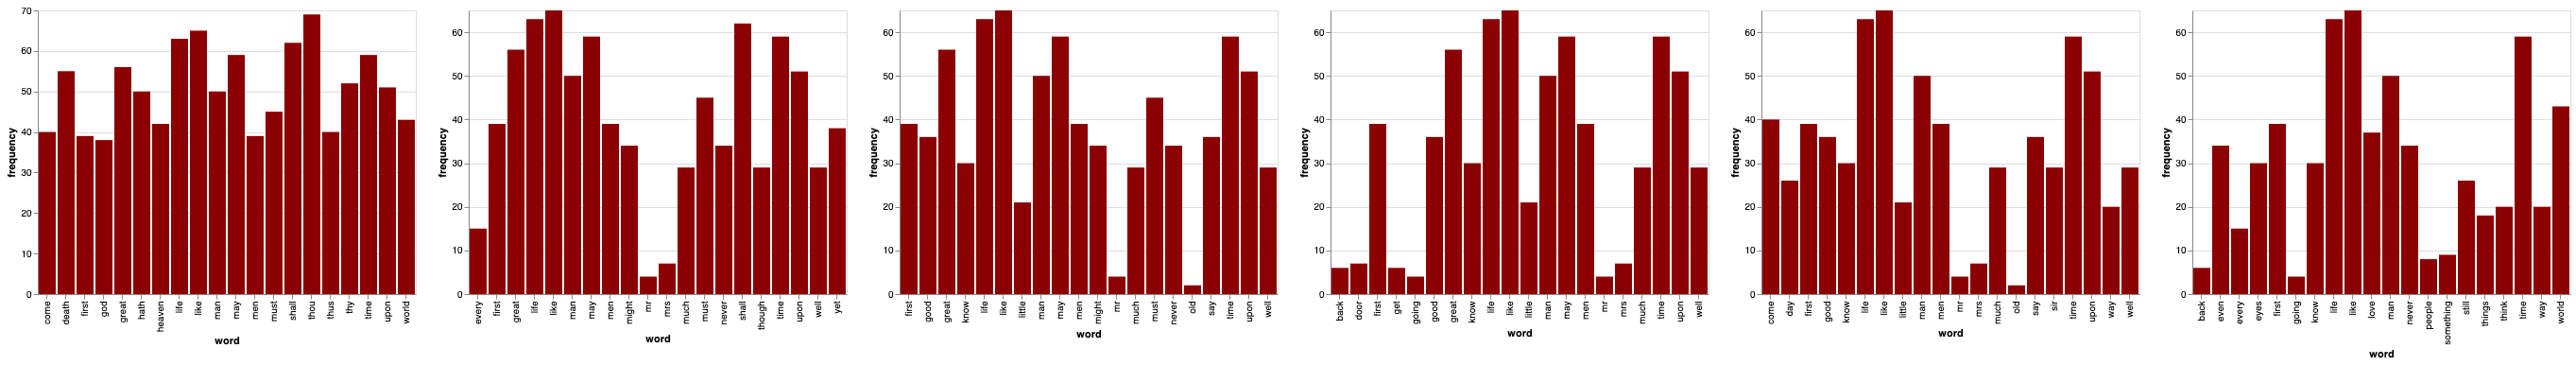

In [20]:
Chart_A = alt.Chart(target0).mark_bar(color='darkred').encode(
    x='word',
    y='frequency'
)

Chart_B = alt.Chart(target1).mark_bar(color='darkred').encode(
    x='word',
    y='frequency'
)

Chart_C = alt.Chart(target2).mark_bar(color='darkred').encode(
    x='word',
    y='frequency'
)

Chart_D = alt.Chart(target3).mark_bar(color='darkred').encode(
    x='word',
    y='frequency'
)

Chart_E = alt.Chart(target4).mark_bar(color='darkred').encode(
    x='word',
    y='frequency'
)

Chart_F = alt.Chart(target5).mark_bar(color='darkred').encode(
    x='word',
    y='frequency'
    )


Chart_A | Chart_B | Chart_C | Chart_D | Chart_E | Chart_F

In [21]:
bivec = CountVectorizer(stop_words=stop, ngram_range=(2, 2))
bigrams = pd.DataFrame(bivec.fit_transform(df['text']).todense(), columns=bivec.get_feature_names())
bigrams['target'] = df['target']

In [22]:
target0_bi = bigrams.groupby('target').sum().T.sort_values(by=0, ascending=False)[[0]].head(20)
target1_bi = bigrams.groupby('target').sum().T.sort_values(by=1, ascending=False)[[0]].head(20)
target2_bi = bigrams.groupby('target').sum().T.sort_values(by=2, ascending=False)[[0]].head(20)
target3_bi = bigrams.groupby('target').sum().T.sort_values(by=3, ascending=False)[[0]].head(20)
target4_bi = bigrams.groupby('target').sum().T.sort_values(by=4, ascending=False)[[0]].head(20)
target5_bi = bigrams.groupby('target').sum().T.sort_values(by=5, ascending=False)[[0]].head(20)

In [23]:

target0 = target0_bi.rename(columns={0: 'frequency'})
target0 = target0.reset_index()
target0 = target0.rename(columns={'index': 'words'})

target1 = target1_bi.rename(columns={0: 'frequency'})
target1 = target1.reset_index()
target1 = target1.rename(columns={'index': 'words'})

target2 = target2_bi.rename(columns={0: 'frequency'})
target2 = target2.reset_index()
target2 = target2.rename(columns={'index': 'words'})

target3 = target3_bi.rename(columns={0: 'frequency'})
target3 = target3.reset_index()
target3 = target3.rename(columns={'index': 'words'})

target4 = target4_bi.rename(columns={0: 'frequency'})
target4 = target4.reset_index()
target4 = target4.rename(columns={'index': 'words'})

target5 = target5_bi.rename(columns={0: 'frequency'})
target5 = target5.reset_index()
target5 = target5.rename(columns={'index': 'words'})

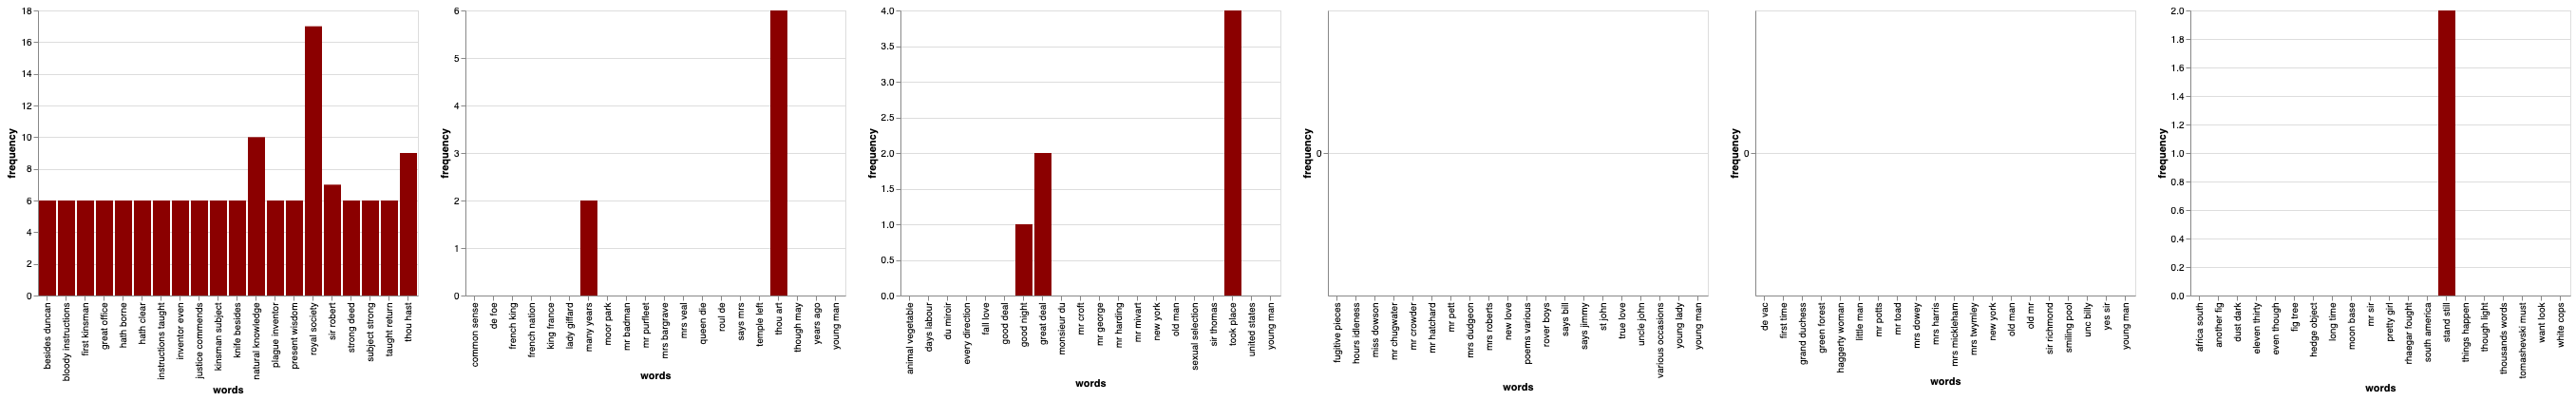

In [24]:
Chart_A = alt.Chart(target0).mark_bar(color='darkred').encode(
    x='words',
    y='frequency'
)

Chart_B = alt.Chart(target1).mark_bar(color='darkred').encode(
    x='words',
    y='frequency'
)

Chart_C = alt.Chart(target2).mark_bar(color='darkred').encode(
    x='words',
    y='frequency'
)

Chart_D = alt.Chart(target3).mark_bar(color='darkred').encode(
    x='words',
    y='frequency'
)

Chart_E = alt.Chart(target4).mark_bar(color='darkred').encode(
    x='words',
    y='frequency'
)

Chart_F = alt.Chart(target5).mark_bar(color='darkred').encode(
    x='words',
    y='frequency'
    )


Chart_A | Chart_B | Chart_C | Chart_D | Chart_E | Chart_F

# LDA

In [25]:
target0 = df[df.target == 0]['text']
target1 = df[df.target == 1]['text']
target2 = df[df.target == 2]['text']
target3 = df[df.target == 3]['text']
target4 = df[df.target == 4]['text']
target5 = df[df.target == 5]['text']
target6 = df[df.target == 6]['text']

In [122]:
lda = LDA(n_components=3, random_state=42)
t0 = cvec.fit_transform(target0)
lda_t0 = lda.fit_transform(t0)
pyLDAvis.sklearn.prepare(lda, t0, cvec)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.023462 -0.119313       1        1  36.798812
0     -0.124898  0.041104       2        1  35.458870
1      0.101436  0.078208       3        1  27.742317, topic_info=     Category       Freq       Term      Total  loglift  logprob
1864  Default  12.000000       heav  12.000000  30.0000  30.0000
2184  Default  19.000000       king  19.000000  29.0000  29.0000
3702  Default  16.000000    society  16.000000  28.0000  28.0000
3164  Default  10.000000  purgatory  10.000000  27.0000  27.0000
1879  Default  13.000000       hell  13.000000  26.0000  26.0000
3422  Default  16.000000      royal  16.000000  25.0000  25.0000
1427  Default  17.000000      faith  17.000000  24.0000  24.0000
3795  Default  13.000000      stage  13.000000  23.0000  23.0000
1848  Default  37.000000       hath  37.000000  22.0000  22.0000
2649  Default  12.000000    natural  12.000000  21.0000  21.0000
1463  Default  18.000000       fear  18.000000  20.0000  20.0000
967   Default  13.000000       deed  13.000000  19.0000  19.0000
4473  Default  11.000000     wisdom  11.000000  18.0000  18.0000
2201  Default  10.000000  knowledge  10.000000  17.0000  17.0000
3122  Default  10.000000   progress  10.000000  16.0000  16.0000
1401  Default  22.000000       eyes  22.000000  15.0000  15.0000
419   Default   7.000000       blow   7.000000  14.0000  14.0000
1124  Default  13.000000     divine  13.000000  13.0000  13.0000
371   Default   9.000000    besides   9.000000  12.0000  12.0000
3003  Default  10.000000     poetry  10.000000  11.0000  11.0000
4017  Default  17.000000         th  17.000000  10.0000  10.0000
4168  Default   7.000000      trust   7.000000   9.0000   9.0000
2679  Default  14.000000      night  14.000000   8.0000   8.0000
4067  Default  40.000000        thy  40.000000   7.0000   7.0000
655   Default  11.000000     christ  11.000000   6.0000   6.0000
2687  Default  13.000000      noble  13.000000   5.0000   5.0000
3648  Default  23.000000        sir  23.000000   4.0000   4.0000
4437  Default  11.000000    whether  11.000000   3.0000   3.0000
1476  Default   9.000000    feeling   9.000000   2.0000   2.0000
1906  Default   9.000000    highest   9.000000   1.0000   1.0000
...       ...        ...        ...        ...      ...      ...
2616   Topic3   6.752228     murder   8.785945   1.0189  -6.3666
1401   Topic3  13.244242       eyes  22.958796   0.7321  -5.6929
3339   Topic3   7.467772       rest  10.275260   0.9631  -6.2659
4437   Topic3   8.180086    whether  11.780258   0.9175  -6.1748
2679   Topic3   8.894599      night  14.047397   0.8252  -6.0910
4066   Topic3  14.432818       thus  30.598786   0.5308  -5.6070
445    Topic3   6.019520      borne   8.060081   0.9903  -6.4815
1865   Topic3  13.615220     heaven  32.196145   0.4216  -5.6653
2241   Topic3   6.013019        lay   8.070813   0.9879  -6.4825
4252   Topic3  14.908054       upon  39.025745   0.3199  -5.5746
2297   Topic3  16.849449       like  49.651361   0.2015  -5.4521
3566   Topic3  16.208137      shall  47.431312   0.2084  -5.4909
948    Topic3  14.678802      death  42.120481   0.2281  -5.5901
2291   Topic3  14.675788       life  48.306584   0.0908  -5.5903
4017   Topic3   8.904041         th  17.137148   0.6275  -6.0900
1257   Topic3   7.449970        end  11.831925   0.8196  -6.2682
2290   Topic3   6.756771       lies  10.330828   0.8576  -6.3659
3833   Topic3   8.907014      still  20.191270   0.4638  -6.0896
2457   Topic3  12.099888        may  45.359713  -0.0392  -5.7833
2356   Topic3  10.030573       love  28.587237   0.2349  -5.9708
2609   Topic3   8.904233       much  22.478176   0.3562  -6.0899
2486   Topic3   9.622471        men  30.158506   0.1398  -6.0124
4513   Topic3   9.619294      world  33.233581   0.0424  -6.0127
709    Topic3   9.405894       come  30.924168   0.0920  -6.0351
1207   Topic3   7.936628      earth  15.648481 

In [ ]:
lda = LDA(n_components=3, random_state=42)
t1 = cvec.fit_transform(target1)
lda_t1 = lda.fit_transform(t1)
pyLDAvis.sklearn.prepare(lda, t1, cvec)

In [ ]:
lda = LDA(n_components=3, random_state=42)
t2 = cvec.fit_transform(target2)
lda_t2 = lda.fit_transform(t2)
pyLDAvis.sklearn.prepare(lda, t2, cvec)

In [ ]:
lda = LDA(n_components=3, random_state=42)
t3 = cvec.fit_transform(target3)
lda_t3 = lda.fit_transform(t3)
pyLDAvis.sklearn.prepare(lda, t3, cvec)

In [ ]:
lda = LDA(n_components=3, random_state=42)
t4 = cvec.fit_transform(target04)
lda_t4 = lda.fit_transform(t4)
pyLDAvis.sklearn.prepare(lda, t4, cvec)

In [ ]:
lda = LDA(n_components=3, random_state=42)
t5 = cvec.fit_transform(target5)
lda_t5 = lda.fit_transform(t5)
pyLDAvis.sklearn.prepare(lda, t5, cvec)

# Sentiment Analysis with Vader

In [26]:
analyzer = SentimentIntensityAnalyzer()

In [27]:
def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
    return score 

In [28]:
df['sentiment'] = df.text.apply(sentiment_analyzer_scores)

In [29]:
df_sent = json_normalize(df.sentiment)

In [30]:
df_sent.tail()

,compound,neg,neu,pos
957,0.0772,0.058,0.875,0.066
958,0.7650,0.076,0.690,0.233
959,0.4767,0.026,0.905,0.069
960,0.2944,0.092,0.788,0.119
961,0.2263,0.000,0.913,0.087


In [31]:
df = df.join((df_sent), how='outer')

In [32]:
# df.to_csv('df_with_sentiment.csv')

In [33]:
df = df.drop(columns=['sentiment'])

In [34]:
compound = df.groupby('target', as_index=False)['compound'].mean()
neg = df.groupby('target', as_index=False)['neg'].mean()
neu = df.groupby('target', as_index=False)['neu'].mean()
pos = df.groupby('target', as_index=False)['pos'].mean()

In [40]:
sentiment_chart = pd.concat([compound, neg, neu, pos], axis=1)

In [41]:
sentiment_chart

,target,compound,target,neg,target,neu,target,pos
0,0,0.212973,0,0.115252,0,0.743959,0,0.140810
1,1,0.509021,1,0.084425,1,0.786094,1,0.129469
2,2,0.651453,2,0.071038,2,0.799371,2,0.129586
3,3,0.590778,3,0.076833,3,0.812978,3,0.110122
4,4,0.373718,4,0.084680,4,0.805670,4,0.109655
5,5,0.111012,5,0.083497,5,0.808687,5,0.107777


In [42]:
sentiment_chart = sentiment_chart.loc[:, ~sentiment_chart.columns.duplicated()]

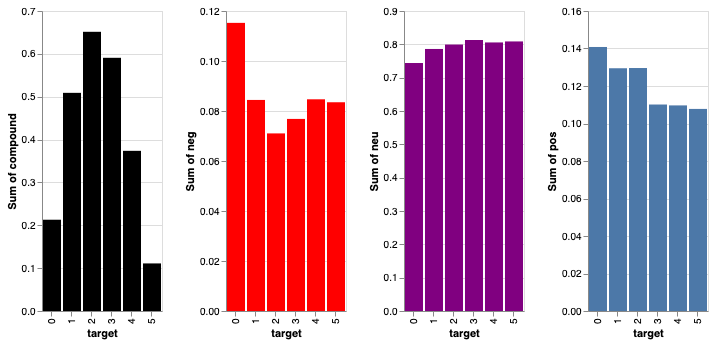

In [43]:
A = alt.Chart(sentiment_chart).mark_bar(color='black').encode(
    x='target:O',
    y='sum(compound):Q'
)

B = alt.Chart(sentiment_chart).mark_bar(color='red').encode(
    x='target:O',
    y='sum(neg):Q'
)

C = alt.Chart(sentiment_chart).mark_bar(color='purple').encode(
    x='target:O',
    y='sum(neu):Q'
)

D = alt.Chart(sentiment_chart).mark_bar().encode(
    x='target:O',
    y='sum(pos):Q'
)

A | B | C | D

In [45]:
df.head()

,date,info,text,target,compound,neg,neu,pos
0,1528,The book of the Courtier,then the soul freed from vice purged by studie...,0,0.9387,0.000,0.800,0.200
1,1569,Hamlet,his goodly frame the earth seems to me a steri...,0,0.9571,0.065,0.719,0.216
2,1592,the spanish tragedy,o eyes no eyes but fountains fraught with tear...,0,-0.9538,0.286,0.575,0.139
3,1569,Hamlet,firmament this majestical roof fretted with go...,0,0.3400,0.121,0.737,0.143
4,1623,macbeth,mine eyes are made the fools o the other sense...,0,-0.9794,0.216,0.711,0.073


# Naive Model

In [15]:
from sklearn.preprocessing import LabelEncoder
X = df['text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)


In [16]:
X_train_counts = cvec.fit_transform(X_train)
X_test_counts = cvec.transform(X_test)

In [17]:
df_counts = pd.DataFrame(X_train_counts.todense(), columns=cvec.get_feature_names())
df_counts.head()

,aadam,abalone,abandon,abandoned,abandoning,abandonment,abasement,abashed,abated,abatement,...,zig,zinc,zobo,zoologists,zoology,zorillo,zorobabel,zounds,zulu,zygote
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train_counts, y_train)
print(f'Train score: {model.score(X_train_counts, y_train)}')
print(f'Test score: {model.score(X_test_counts, y_test)}')

Train score: 1.0
Test score: 0.6683937823834197


In [19]:
y_pred = model.predict(X_test_counts)

In [20]:
def classification_metrics(y_test, y_pred):
    print(f' Accuracy Score: {accuracy_score(y_test, y_pred)}')
    print(f' Precision Score: {precision_score(y_test, y_pred, average = None)}')
    print(f' Recall Score: {recall_score(y_test, y_pred, average = None)}')
    
classification_metrics(y_test, y_pred)

 Accuracy Score: 0.6683937823834197
 Precision Score: [0.8        0.625      0.78787879 1.         0.58695652 0.54716981]
 Recall Score: [0.74074074 0.57692308 0.65       0.5        0.65853659 0.82857143]


In [21]:
confusion_matrix(y_test, y_pred)

array([[20,  1,  0,  0,  1,  5],
       [ 3, 15,  2,  0,  3,  3],
       [ 2,  6, 26,  0,  3,  3],
       [ 0,  0,  3, 12,  7,  2],
       [ 0,  1,  2,  0, 27, 11],
       [ 0,  1,  0,  0,  5, 29]])

In [22]:
predictions = model.predict(X_test_counts)

comparison = pd.DataFrame(predictions, y_test)
comparison = comparison.reset_index()

In [27]:
comparison['prediction'] = comparison['prediction'].astype(int)

In [28]:
comparison['correct'] = np.where(comparison['target'] == comparison['prediction'], 1, 0)

In [29]:
comparison = comparison.rename(columns={0: 'prediction'})

In [30]:
comparison.target = comparison.target.astype(int)

In [31]:
comparison.tail()

,target,prediction,correct
188,2,1,0
189,0,0,1
190,0,0,1
191,4,5,0
192,5,5,1


In [32]:
comparison['difference'] = abs(comparison.target - comparison.prediction)

In [33]:
borderline_dates = len(comparison[comparison['difference'] < 1]) / len(comparison['difference'])
borderline_dates

0.6683937823834197

In [35]:
df = pd.read_csv('../data/cleaned/df_with_sentiment_doc2vec.csv', index_col=0)

In [36]:
df.tail(10)

,date,info,text,target,sentiment,compound,neg,neu,pos,doc_2_vec
952,1981,Midnight's Children,"['yes', 'they', 'will', 'trample', 'me', 'unde...",5,"{'neg': 0.136, 'neu': 0.783, 'pos': 0.081, 'co...",-0.8316,0.136,0.783,0.081,0.206581
953,2003,A Hundred and One Days,"['the', 'white', 'floodlight', 'shines', 'thro...",5,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,1.000,0.000,0.028123
954,1959,Cider With Rosie,"['it', 'was', 'then', 'that', 'began', 'to', '...",5,"{'neg': 0.0, 'neu': 0.978, 'pos': 0.022, 'comp...",0.0772,0.000,0.978,0.022,0.133808
955,1954,Lord of the Flies,"['he', 'turned', 'away', 'to', 'give', 'them',...",5,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,1.000,0.000,0.061380
956,1991,The Kitchen God's Wife,"['of', 'course', 'it', 'only', 'superstition',...",5,"{'neg': 0.0, 'neu': 0.691, 'pos': 0.309, 'comp...",0.8945,0.000,0.691,0.309,0.035997
957,1998,The Hours,"['and', 'here', 'she', 'is', 'herself', 'clari...",5,"{'neg': 0.058, 'neu': 0.875, 'pos': 0.066, 'co...",0.0772,0.058,0.875,0.066,0.058215
958,1985,Perfume: The Story of a Murderer,"['when', 'they', 'finally', 'did', 'dare', 'it...",5,"{'neg': 0.076, 'neu': 0.69, 'pos': 0.233, 'com...",0.7650,0.076,0.690,0.233,0.066629
959,1999,White Teeth,"['archie', 'for', 'one', 'watched', 'the', 'mo...",5,"{'neg': 0.026, 'neu': 0.905, 'pos': 0.069, 'co...",0.4767,0.026,0.905,0.069,0.106366
960,2002,Any Human Heart,"['my', 'personal', 'rollercoaster', 'not', 'so...",5,"{'neg': 0.092, 'neu': 0.788, 'pos': 0.119, 'co...",0.2944,0.092,0.788,0.119,0.015476
961,2008,The Outcast,"['he', 'didn', 'think', 'about', 'it', 'he', '...",5,"{'neg': 0.0, 'neu': 0.913, 'pos': 0.087, 'comp...",0.2263,0.000,0.913,0.087,0.050174
